

# Average age of Dutch politicians

On Twitter I came across a [tweet](https://twitter.com/WaltHickey/status/1569827673760845826) that alarmingly noted that the percentage of members of congress that are over 70 is increasing exponentially. This caught my interest and I wanted to see if a similar trend was also happening here in the Netherlands.

To retrieve the data I used the data query engine that is provided free of charge by the Wikipedia foundation. It uses the SPARQL query language which is very powerful and quite fun to use, even though it did take me some time to [familiarize myself with the syntax](https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial).

Using the language I came up with the following [query](https://query.wikidata.org/#SELECT%20%3Fmember%20%3Fdob%20%3Fstart%20%3Fend%20%3FmemberLabel%0AWHERE%20%7B%0A%20%20%3Fmember%20wdt%3AP39%20wd%3AQ18887908%3B%0A%20%20%20%20%20%20%20%20%20%20wdt%3AP569%20%3Fdob.%0A%0A%20%20%7B%20%3Fmember%20p%3AP39%20%3Fposition.%0A%20%20%3Fposition%20ps%3AP39%20wd%3AQ18887908%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20pq%3AP580%20%3Fstart.%20%7D%0A%20%20%0A%20%20OPTIONAL%20%7B%20%3Fmember%20p%3AP39%20%3Fposition.%0A%20%20%3Fposition%20ps%3AP39%20wd%3AQ18887908%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20pq%3AP582%20%3Fend.%20%7D%0A%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%22.%20%7D%0A%7D%20ORDER%20BY%20DESC%28%3Fstart%29%20) to retrieve all the members of the Dutch house of representatives (2e kamer), the date of birth and their time in office.

```
SELECT ?member ?dob ?start ?end ?memberLabel
WHERE {
  ?member wdt:P39 wd:Q18887908;
          wdt:P569 ?dob.

  { ?member p:P39 ?position.
  ?position ps:P39 wd:Q18887908;
            pq:P580 ?start. }
  
  OPTIONAL { ?member p:P39 ?position.
  ?position ps:P39 wd:Q18887908;
            pq:P582 ?end. }
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
} ORDER BY DESC(?start) 
```

I saved the results of the query in a JSON file and I did the same for the Prime Ministers.

In [47]:
import json
import matplotlib.pyplot as plt
from datetime import date, datetime


In [48]:
def calc_age(birthdate, at_date):
    age = at_date.year - birthdate.year - ((at_date.month, at_date.day) < (birthdate.month, birthdate.day))
    return age

In [49]:
file = open('dutch-house-of-representatives.json')
members = json.load(file)
file.close()

years = range(1850, 2022)

members_at_year = dict()
    
for year in years:
    for m in members:
        current_date = datetime(year, 1, 1)
        start_date = datetime.strptime(m["start"], '%Y-%m-%dT%H:%M:%SZ')
        if "end" in m:
            end_date = datetime.strptime(m["end"], '%Y-%m-%dT%H:%M:%SZ')
        else:
            # fallback end date, assume member will be out of office after 4 years
            today = datetime.today()
            end_date = datetime(today.year + 4, today.month, today.day)
        
        if start_date <= current_date <= end_date:
            date_of_birth = datetime.strptime(m["dob"], '%Y-%m-%dT%H:%M:%SZ')
            age = calc_age(date_of_birth, current_date)
            
            if year in members_at_year:
                members_at_year[year].append(age)
            else:
                members_at_year[year] = [age] 

average_age_members=[]

for year, members in members_at_year.items():
    average_age_members.append(round(sum(members) / len(members)))
    

In [50]:
file = open('age-of-dutch-prime-ministers.json')
ministers = json.load(file)
file.close()

prime_minister_ages = []
    
for year in years:
    for m in ministers:
        current_year = datetime(year, 1, 1)
        start_date = datetime.strptime(m["start"], '%Y-%m-%dT%H:%M:%SZ')
        end_date = datetime.strptime(m["end"], '%Y-%m-%dT%H:%M:%SZ')
        
        if start_date <= current_year <= end_date:
            date_of_birth = datetime.strptime(m["dob"], '%Y-%m-%dT%H:%M:%SZ')
            age = calc_age(date_of_birth, current_year)
            prime_minister_ages.append(age)

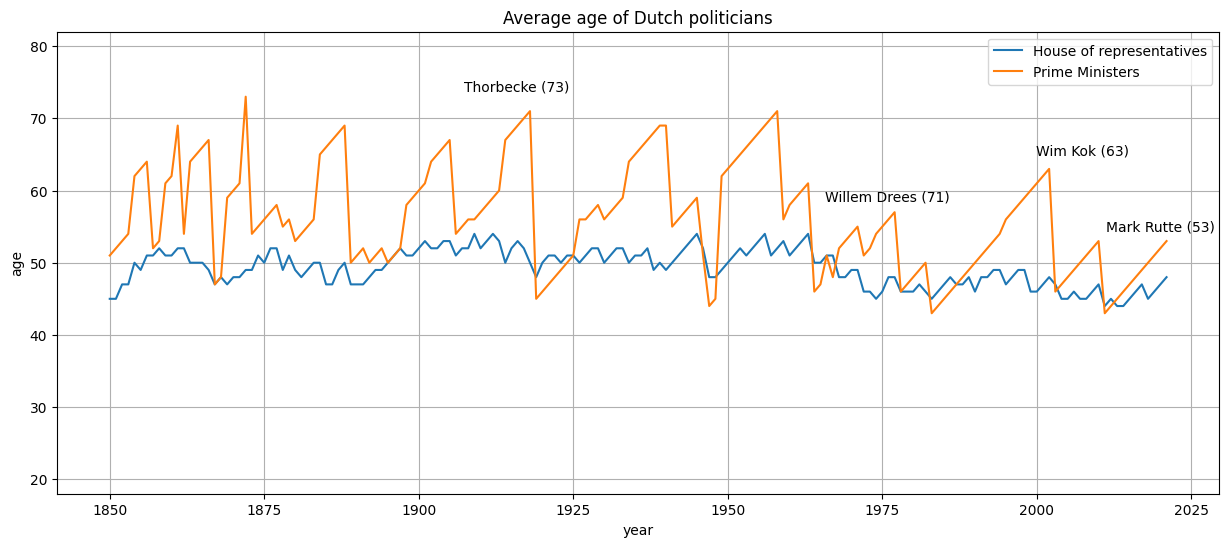

In [51]:
plt.subplots(figsize=(15, 6))

plt.plot(years, average_age_members, label="House of representatives")
plt.plot(years, prime_minister_ages, label="Prime Ministers")
plt.legend()
plt.ylim(18, 82)
plt.grid()
plt.title("Average age of Dutch politicians")
plt.ylabel("age")
plt.xlabel("year")

plt.annotate('Thorbecke (73)',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-650, 400), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')


plt.annotate('Willem Drees (71)',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-270, 290), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')

plt.annotate('Wim Kok (63)',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-90, 350), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='top')

plt.annotate('Mark Rutte (53)',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-5, 260), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')

plt.show()
